In [1]:
import math
from datetime import datetime, timedelta
import calendar
import time
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

dayMs = 1000 * 60 * 60 * 24
J1970 = 2440588
J2000 = 2451545
rad = math.pi / 180.0
e = rad * 23.4397
cell_area = 0.0153 #m^2

def altitude(H, phi, dec):
    return math.asin(math.sin(phi) * math.sin(dec) + math.cos(phi) * math.cos(dec) * math.cos(H))

def azimuth(H, phi, dec):  
    return math.atan2(math.sin(H), math.cos(H) * math.sin(phi) - math.tan(dec) * math.cos(phi))

def siderealTime(d, lw):
     return rad * (280.16 + 360.9856235 * d) - lw

def rightAscension(l, b): 
    return math.atan2(math.sin(l) * math.cos(e) - math.tan(b) * math.sin(e), math.cos(l))

def declination(l, b):    
    return math.asin(math.sin(b) * math.cos(e) + math.cos(b) * math.sin(e) * math.sin(l))

def toJulian(date):
    return (time.mktime(date.timetuple()) * 1000) / dayMs - 0.5 + J1970

def toDays(date):   
    return toJulian(date) - J2000

def solarMeanAnomaly(d):
    return rad * (357.5291 + 0.98560028 * d)

def eclipticLongitude(M):
    C = rad * (1.9148 * math.sin(M) + 0.02 * math.sin(2 * M) + 0.0003 * math.sin(3 * M)) # equation of center
    P = rad * 102.9372 # perihelion of the Earth
    return M + C + P + math.pi

def sunCoords(d):
    M = solarMeanAnomaly(d)
    L = eclipticLongitude(M)
    return dict(
        dec= declination(L, 0),
        ra= rightAscension(L, 0)
    )

def getSunPosition(date, lat, lng):
    """Returns positional attributes of the sun for the given time and location."""
    lw  = rad * -lng
    phi = rad * lat
    d   = toDays(date)

    c  = sunCoords(d)
    H  = siderealTime(d, lw) - c["ra"]
    # print("d", d, "c",c,"H",H,"phi", phi)
    return dict(
        azimuth=azimuth(H, phi, c["dec"]),
        altitude=altitude(H, phi, c["dec"])
    )

def getElevation(lat,lon):
    year = 2020
    api_key = 'oHJ9olM4GSKZjaLsf51aTqxd5kyaVTFL7t47pla1'
    utc = 'false'
    your_name = 'Aryan+Misra'
    reason_for_use = 'beta+testing'
    your_affiliation = 'mcmaster+university'
    your_email = 'aryanmisra4@gmail.com'
    mailing_list = 'false'
    leap_year = 'false'
    interval = '30'
    attributes = 'ghi,dhi,dni,wind_speed,air_temperature'
    url = 'https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
    info = pd.read_csv(url, nrows=1)
    return info['Elevation'].values[0]

def cell_solar_irradiance(lat, lon, time, module_tilt, car_azimuth_angle, elevation):
    
    sunPosition = getSunPosition(time, lat, lon)
#     print("sunPosition: ", sunPosition)
    sun_elevation_angle = math.degrees(sunPosition['altitude'])
    if sun_elevation_angle < 0:
        sun_elevation_angle = 360 + sun_elevation_angle
#     print("sun_elevation_angle (deg): ", sun_elevation_angle)
    sun_azimuth_angle = math.degrees(sunPosition['azimuth'])
    if sun_azimuth_angle < 0:
        sun_azimuth_angle = 360 + sun_azimuth_angle
#     print("sun_azimuth_angle (deg): ", sun_azimuth_angle)
    
    #https://www.pveducation.org/pvcdrom/properties-of-sunlight/air-mass#AMequation
    #s_incident measured in kW/m^2 should be retrieved empirically
    air_mass = 1/(math.cos(math.radians(90-sun_elevation_angle)) + 0.50572*(96.07995-(90-sun_elevation_angle))**-1.6364) 
#     print("air_mass: ", air_mass)
#     print("elevation (km): ", elevation)
    
    s_incident_diffuse = 1.1*1.353*((1-0.14*elevation)*0.7**air_mass**0.678 + 0.14*elevation)
    print("s_incident_diffuse (kW/m^2): ", s_incident_diffuse)
    
    s_cell_diffuse = s_incident_diffuse*(math.cos(math.radians(sun_elevation_angle))*math.sin(math.radians(module_tilt))*math.cos(math.radians(car_azimuth_angle - sun_azimuth_angle)) 
                     + math.sin(math.radians(sun_elevation_angle))*math.cos(math.radians(module_tilt)))
#     print("s_cell_diffuse (kW/m^2): ", s_cell_diffuse)
#     print("s_cell (kW): ", s_cell_diffuse*cell_area)
    
    return s_cell_diffuse*cell_area

In [7]:
cell_solar_irradiance(43.260731, -79.9238337, datetime(2023, 8, 21, 16, 0, 0), 3, 270, 900)
# getElevation(43.260731, -79.9238337)

s_incident_diffuse (kW/m^2):  69.57211201307912


0.7054261350940249

In [8]:
#module_tilts is a dictionary with keys being module id's and values being tilts

hood_front = {
    "left_stairs": [33.38, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44],
    "left_center_3x4": [33.38, 33.38, 33.38, 27.64, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44],
    "right_center_3x4": [33.38, 33.38, 33.38, 27.64, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44],
    "right_stairs": [33.38, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44]
}

top_front = {
    "leftmost_top_3x2": [28.52, 28.52, 28.52, 22.16, 22.16, 22.16],
    "leftmost_center_3x2": [22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
    "leftmost_bottom_3x2": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14],
    "leftcenter_top_3x2": [28.52, 28.52, 28.52, 22.16, 22.16, 22.16],
    "leftcenter_center_3x2": [22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
    "leftcenter_bottom_3x2": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14],
    "rightcenter_top_3x2": [28.52, 28.52, 28.52, 22.16, 22.16, 22.16],
    "rightcenter_center_3x2": [22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
    "rightcenter_bottom_3x2": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14],
    "rightmost_top_4x3": [28.52, 28.52, 28.52, 28.52, 22.16, 22.16, 22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
    "rightmost_bottom_4x3": [22.16, 22.16, 22.16, 22.16, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14]
}

top_back = {
    "leftmost_3x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64],
    "leftcenter_3x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64],
    "rightcenter_3x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64],
    "rightmost_4x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64, -3.64]
}

back = {
    "leftmost_top_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
    "leftcenter_top_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
    "rightcenter_top_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
    "rightmost_top_4x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
    "leftmost_bottom_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
    "leftcenter_bottom_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64], 
    "rightcenter_bottom_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
    "rightmost_bottom-4x4": [-4, -4, -4, -4, -5, -5, -5, -5, -6, -6, -6, -6]
}

#solar irradiance hitting a section
def section_solar_irradiance(lat, lon, time, module_tilts, car_azimuth_angle):
    total_sum = 0;
    #store solar irradiance value of similar angles in a dictionary and use it to approximate?
    #definitely keep reference of same values to limit api calls
    for module in module_tilts.keys():
        module_sum = 0;
        for cell_angle in module_tilts[module]:
            cell_irr = cell_solar_irradiance(lat, lon, time, cell_angle, car_azimuth_angle)
            print("cell_irr: ", cell_irr)
            module_sum += cell_irr
        print("module sum: ", module_sum)
        total_sum += module_sum
    return total_sum
            

In [9]:
#irradiance to power conversion with lin regression fit
#1kw - 290 W
#.9kW - 260 W
#.8kW - 230 W
#.7kW - 200 W
#.6kW - 170 W
#.5kW - 141 W
#.4kW - 112 W
#.3kW - 83 W
#.2kW - 54 W

xData = np.array([200, 300, 400, 500, 600, 700, 800, 900, 1000]).reshape((-1,1))
yData = np.array([54, 83, 112, 141, 170, 200, 230, 260, 290])
irrToPowerModel = LinearRegression()
irrToPowerModel.fit(xData, yData)
r_sq = irrToPowerModel.score(xData,yData)
print(f"coefficient of determination: {r_sq}")
print(f"slope: {irrToPowerModel.coef_}")

coefficient of determination: 0.9999255271613081
slope: [0.295]


[[ 200]
 [ 300]
 [ 400]
 [ 500]
 [ 600]
 [ 700]
 [ 800]
 [ 900]
 [1000]]


(0.0, 290.0)

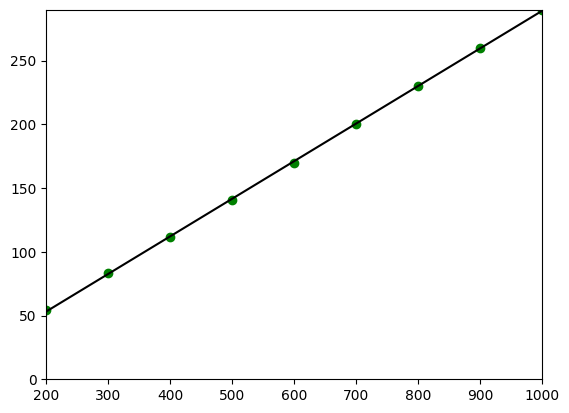

In [10]:
yPred = irrToPowerModel.predict(xData)
print(xData)
plt.scatter(xData, yData, color='g')
plt.plot(xData, yPred, color='k')
ax = plt.gca()
ax.set_xlim([xData[0], xData[len(xData)-1]])
ax.set_ylim([0, yData[len(yData)-1]])
#model exponential function for relationship between irradiance and power output
#voltage of max power point in non ideal conditions

In [11]:
conf = [
    {
        "v": 40,  # v0, d0
        "d": 26 # t0 = 0.65
    },
    {
        "v":50, #t1 = 1.32
        "d": 66
    },
    {
        "v": 60, #t2 = 3.167
        "d": 190
    },
    {
        "v": 48, #t3 = 1.77
        "d": 85
    },
    {
        "v": 44, #t4 = 0.68
        "d": 30
    }
] #v_i represents average velocity over given segment, d_i represents distance covered during that segment
def v(t, config):
    d_total = 0
    timeRem = t
    for seg in config:
        segTime = seg["d"] / seg["v"]
        if(timeRem <= segTime):
            return seg["v"]
        else:
            d_total += seg["d"]
            timeRem -= segTime

def vTwa(config):
    timeTot = 0
    dTot = 0
    for seg in config:
        dTot += seg["d"]
        timeTot += seg["d"] / seg["v"]
    return dTot / timeTot

#each array index will be referred to as a "step" in the route segment
exRouteSeg = [
    {
        "dist": 0.05,
        "speed": 20,
        "ss": 1,
    },
    {
        "dist": 0.1,
        "ss": 1,
    },
    {
        "dist": 0.05,
        "ss": 1,
    },
    {
        "dist": 0.3,
        "ss": 1
    },
    {
        "dist": 0.2,
        "sl": 1
    },
    {
        "dist": 0.3,
        "speed": 30,
        "sl": 1
    },
    {
        "dist": 0.5,
        "sl": 1
    },
    {
        "dist": 0.1,
        "speed": 35
    }
]

def timeToReachStep(stepIndex, routeSegment):
    time = 0
    v = 0
    totalDist = 0
    for i in range(0, stepIndex):
        if("speed" in routeSegment[i]):
            v = routeSegment[i]["speed"]
        
        #step's avg velocity must be derived from speed limit and traffic conditions
        sV = v*0.8
        #fix to more accurately represent decrease in avg velocity as a function of route segment distance 
        #and number of stop signs/traffic lights.
        if("ss" in routeSegment[i]):
            sV -= routeSegment[i]["ss"]/(20*routeSegment[i]["dist"]) 
        
        if("sl" in routeSegment[i]):
            sV -= routeSegment[i]["sl"]/(30*routeSegment[i]["dist"]) 
        time += routeSegment[i]["dist"]/sV

    return time*60

print(timeToReachStep(7, exRouteSeg))

#from lat lon position of car, return azimuth angle and angle of elevation if u can
#def posToAngle() 

SyntaxError: invalid syntax (2179640929.py, line 104)